In [1]:
import numpy as np
import torch
import seaborn as sns

A simple hypothesis function is the dot/inner product of two vectors :

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix} + b
$$

$$
y = sigmoid(h)
$$


In [2]:
def sigmoid_activation(h):
    return 1/(1 + torch.exp(-h))

In [3]:
### Generate some synthetic data
torch.manual_seed(13) 

n_features = 10
m_examples = 1

# create X vector sampled from a gaussian distribution
X = torch.randn((m_examples,n_features))
# create W vector sampled from a gaussian distribution with the same shape of X 
W = torch.rand_like(X)
# create bias vector 
b = torch.randn(m_examples,m_examples)


In [4]:
# There are two different methods in pytorch to do matrix multiplcations
# 1. using * but it is too risky as if X and W dimensions are not consistent, * will do broadcasting to unify the dimensions.
y = sigmoid_activation((X*W).sum() + b)

# 2. using torch.mm or torch.matmul which raise error in case if the dimensions are not consistent like the following example

y = sigmoid_activation(torch.mm(X,W) + b)

RuntimeError: size mismatch, m1: [1 x 10], m2: [1 x 10] at /Users/soumith/miniconda2/conda-bld/pytorch_1532624435833/work/aten/src/TH/generic/THTensorMath.cpp:2070

In [5]:
# We need to transpose W vector before doing dot product , there are three methods in pytorch to do so 
# 1. W.reshape(rows,columns) returns a new vector with the new shape and keeps clone of the original W in the memory. This is not efficient as it copies all the data in the memory. Sometimes, it returns a new view of W when possible.
# 2. W.resize_(rows,columns) resizes W inplace. The problem with resize_ is that if the new shape results fewer than elements than the old shape, some of the elements will be truncated.
# 3. W.view(rows,columns) returns new tensor of W with the new shape.

y = sigmoid_activation(torch.mm(X,W.view(n_features,m_examples)) + b)

Now, consider a simple NN with 3 inputs and 2 hidden layers. 
<br>
The first weights matrix W1 dimensions should be (num_of_features,num_of_hidden_layers).
<br>
The second weights matrix W2 dimensions should be (num_of_hidden_layers,output_dimension).
<br>

$$
h_{(m,hidden)} = sigmoid(X_{(m,n)} * W1_{(n,hidden)} + b1_{(m,hidden)}) 
$$
<br>
$$
output_{(m,output\_dim)} = sigmoid(h_{(m,hidden)} * W2_{(hidden,output\_dim)} + b2_{(m,output\_dim)}) 
$$



In [6]:
num_features = 3
num_hidden_layers = 2
m_examples = 500
n_output_dimensions = 1
learning_rate = 0.001

#create dummy examples
X = torch.randn(m_examples,num_features)
#create dummy labels
y = torch.bernoulli(sigmoid_activation(torch.randn(m_examples,n_output_dimensions)))

W1 = torch.randn(num_features,num_hidden_layers)
W2 = torch.randn(num_hidden_layers,n_output_dimensions)
#b1 = torch.randn(m_examples,num_hidden_layers)
#b2 = torch.randn(m_examples,n_output_dimensions)
error_by_epoch = []
for epoch in range(100):
    #one feedforward step
    h = sigmoid_activation(torch.mm(X,W1))
    predictions = sigmoid_activation(torch.mm(h,W2))
    assert predictions.shape[0] == m_examples
    assert predictions.shape[1] == n_output_dimensions

    cross_entropy_loss = - y*torch.log(predictions) - (1 - y) * torch.log(1-predictions)
    error_by_epoch.append(torch.sum(cross_entropy_loss).item())
    # Backprop to compute gradients of w1 and w2 with respect to the loss
    grad_y_pred = (predictions - y)
    grad_w2 = h.t().mm(grad_y_pred)
    grad_h_sigmoid = grad_y_pred.mm(W2.t())
    grad_h = grad_h_sigmoid.clone()
    grad_w1 = X.t().mm(grad_h)

    # Update weights using gradient descent
    W1 -= learning_rate * grad_w1
    W2 -= learning_rate * grad_w2
    

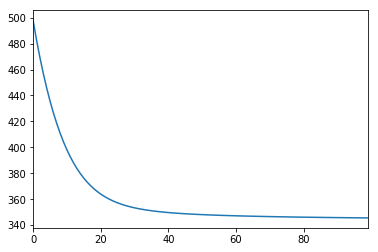

In [8]:
sns.tsplot(error_by_epoch,range(len(error_by_epoch)))